In [1]:
import os

# Set cuda device to use
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# do not prealocate memory
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

%matplotlib inline
sns.set_theme(context='paper', style='white', font_scale=1.6, color_codes=True)

In [1]:
import jax.numpy as jnp
import equinox as eqx
import optax
import augmax

from functools import partial

from tensorflow_probability.substrates.jax.stats import expected_calibration_error as compute_ece
from jax import random as jr, nn, vmap, lax
import jax.tree_util as jtu

from mlpox import DeepMlp, MlpMixer

from blrax.optim import ivon
from blrax.utils import parallel_value_and_grad, get_scale, sample_posterior

rng_key = jr.PRNGKey(0)

ImportError: /home/dima/.conda/envs/bmr/lib/python3.12/site-packages/jaxlib/xla_extension.so: cannot enable executable stack as shared object requires: Invalid argument

In [4]:
def del_f(mu, scale, prior_scale=1.):
    return (jnp.log(prior_scale) - jnp.log(scale)) - .5 * jnp.square(mu / scale)

def run_training(key, nnet, optim, train_ds, test_ds, num_epochs=10, batch_size=128, start_pruning=10, eps=.0):
    """
    Train a neural network using Equinox and Optax.
    
    Args:
        key: JAX PRNG key
        nnet: Equinox neural network
        optim: Optax (or blrax) optimizer
        train_ds: Training dataset dictionary with 'image' and 'label' keys
        test_ds: Test dataset dictionary with 'image' and 'label' keys
        num_epochs: Number of epochs to train
        batch_size: Batch size for training
    """
    
    # Initialize optimizer state
    num_classes = len(jnp.unique(test_ds['label']))
    params, static = eqx.partition(nnet, eqx.is_array)
    mask = jtu.tree_map(lambda x: jnp.ones_like(x, jnp.bool), params) 
    opt_state = optim.init(params)
    n_samples = len(train_ds['image'])
    img_shape = train_ds['image'].shape[-3:]
    steps_per_epoch = n_samples // batch_size
    
    # Cross entropy loss function
    def loss_fn(params, x, y, key=None):
        model = eqx.combine(params, static)
        logits = vmap(partial(model, key=key))(x)
        _y = jnp.clip(nn.one_hot(y, num_classes), min=eps/num_classes, max=1 - (num_classes - 1) * eps / num_classes)
        return optax.softmax_cross_entropy(logits, _y).mean()
    
    # Training step function
    @eqx.filter_jit
    def train_step(loss_fn, params, opt_state, x, y, mask, key):
        loss_value, grads = parallel_value_and_grad(loss_fn, opt_state[0], params, x, y, key, mask=mask)
        updates, opt_state = optim.update(grads, opt_state, params)
        updates = jtu.tree_map(lambda g, m: g * m, updates, mask)
        params = optax.apply_updates(params, updates)
        return params, opt_state, loss_value
    
    # Evaluation function
    @eqx.filter_jit
    def evaluate(params, images, labels):
        def evnet(params):
            model = eqx.nn.inference_mode(eqx.combine(params, static))
            return vmap(model)(images)
        
        logits = evnet(params)
            
        predictions = jnp.argmax(logits, axis=1)
        acc = jnp.mean(predictions == labels)
        nll = optax.softmax_cross_entropy_with_integer_labels(logits, labels).mean()
        ece = compute_ece(20, logits=logits, labels_true=labels, labels_predicted=predictions)
        return acc, nll, ece
    
    # Inner training loop (one epoch)
    def train_epoch(carry, xs):
        params, mask, opt_state = carry
        key, epoch = xs
        
        # Shuffle training data
        key, _key = jr.split(key)
        perm = jr.permutation(_key, n_samples)
        train_images = train_ds['image'][perm]
        train_labels = train_ds['label'][perm]
        
        def train_step_scan(carry, xs):
            params, opt_state, key = carry
            
            batch_images, batch_labels = xs
            key, _key = jr.split(key)
            params, opt_state, loss_value = train_step(
                loss_fn, params, opt_state, batch_images, batch_labels, mask, _key
            )
            return (params, opt_state, key), loss_value
        
        # Run training steps for one epoch
        data = (
            train_images[:steps_per_epoch * batch_size].reshape(steps_per_epoch, batch_size, *img_shape),
            train_labels[:steps_per_epoch * batch_size].reshape(steps_per_epoch, batch_size)
        )
        init_carry = (params, opt_state, key)
        (params, opt_state, key), losses = lax.scan(
            train_step_scan,
            init_carry,
            data
        )

        start = epoch > start_pruning
        select = partial(jnp.where, start)

        if hasattr(opt_state[0], "sample_params"):
            sigma = get_scale(opt_state[0])
            mask = jtu.tree_map(lambda m, s, t: select(t * (del_f(m, s) <= 0), t), params, sigma, mask)
            pruned_fraction = jtu.tree_map( lambda m: jnp.mean(~m), mask)
            _params = jtu.tree_map(lambda m, t: t * m, params, mask)
        else:
            pruned_fraction = 0.
            _params = params
        
        # Calculate metrics
        key, _key = jr.split(key)
        acc, nll, ece = evaluate(
            params,
            test_ds['image'],
            test_ds['label'],
        )
        
        metrics = {
            'loss': losses.sum() / steps_per_epoch,
            'acc': acc,
            'ece': ece,
            'nll': nll,
            'pf': pruned_fraction
        }
        
        return (_params, mask, opt_state), metrics
    
    # Run training for multiple epochs
    keys = jr.split(key, num_epochs)
    init_carry = (params, mask, opt_state)
    (params, mask, final_opt_state), metrics = lax.scan(
        train_epoch,
        init_carry,
        (keys, jnp.arange(num_epochs))
    )
    trained_model = eqx.combine(params, static)
    return trained_model, final_opt_state, metrics

In [5]:
def standardize(train_images, test_images, num_channels=1):
    mean = train_images.reshape(-1, num_channels).mean(0)
    std = train_images.reshape(-1, num_channels).std(0)

    return (train_images - mean) / std, (test_images - mean) / std

def plot_performance(results, num_epochs):
    fig, axes = plt.subplots(1, 3, figsize=(16, 4), sharex=True)

    for key in results:
        vals = results[key]
        if vals is not None:
            for ax, lbl in zip(axes, ['acc', 'ece', 'nll']):
                ax.plot(range(1, num_epochs + 1), vals[lbl], 'o:', label=key)
                ax.set_xlabel('epoch')
                ax.set_title(lbl)

    axes[0].legend(title='method', fontsize=12)
    axes[0].set_ylim([.7, 1.])
    fig.tight_layout()

    return fig

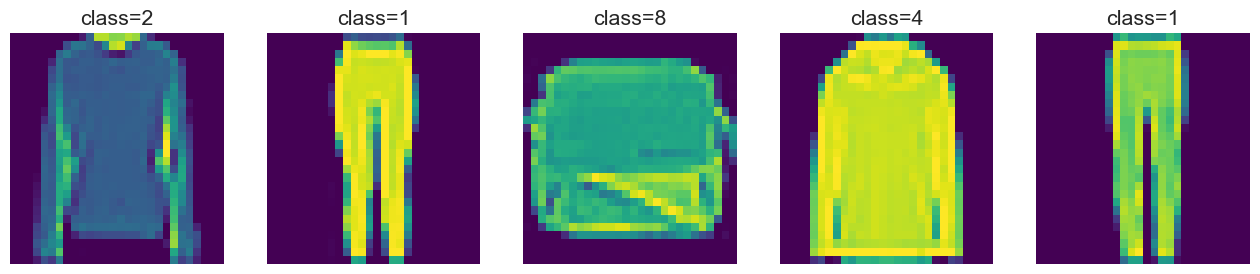

In [6]:
# load data
train_ds, test_ds = load_data('fashion_mnist', platform='gpu', id=0)

in_size = train_ds['image'].shape[-3:]
out_size = len(jnp.unique(train_ds['label']))

fig, axes = plt.subplots(1, 5, figsize=(16, 3), sharex=True, sharey=True)
for n in range(5):
    sns.heatmap(
        train_ds['image'][n].squeeze() / 255, 
        cmap='viridis', 
        ax = axes[n], 
        cbar=False, 
        vmax=1., 
        vmin=0.,
        xticklabels="",
        yticklabels=""
    )
    axes[n].set_title('class={}'.format(train_ds['label'][n]))

train_ds['image'], test_ds['image'] = standardize(train_ds['image'], test_ds['image'], num_channels=1)

# Standard MLP

In [157]:
augment = augmax.Chain(
  augmax.RandomSizedCrop(28, 28),
  augmax.HorizontalFlip()
)

In [158]:
rng_key, key = jr.split(rng_key)
smlp = DeepMlp(
        img_size=in_size[:-1],
        in_channels=in_size[-1],
        embed_dim=256,
        num_classes=10,
        num_blocks=6,
        activation=nn.relu,
        augmentation=augment,
        type="standard",
        inference=False,
        key=key
)

In [185]:
batch_size = 512
num_epochs = 400

num_iters = num_epochs * len(train_ds['image']) // batch_size

lr_schd = optax.schedules.warmup_cosine_decay_schedule(
    1e-3,
    1e-2,
    num_iters // 10,
    num_iters,
    1e-4
)

optimizer1 = optax.adamw(lr_schd)

optimizer2 = optax.lion(1e-4, weight_decay=1e-5)

In [186]:
mus = []
results = []

for optim in [optimizer1, optimizer2]:
    rng_key, key = jr.split(rng_key)
    trained_smlp, final_opt_state, metrics = run_training(
        key,
        smlp, 
        optim, 
        train_ds, 
        test_ds, 
        num_epochs=num_epochs, 
        batch_size=batch_size
    )

    state = final_opt_state[0]
    params = eqx.filter(trained_smlp, eqx.is_array)
        
    mus.append(params)
    results.append(metrics)

In [187]:
num_iters = num_epochs * len(train_ds['image']) // batch_size

lr_schd = optax.schedules.warmup_cosine_decay_schedule(
    1e-2,
    1e-1,
    num_iters // 10,
    num_iters,
    1e-4
)

rng_key, key = jr.split(rng_key)
optimizer3 = ivon(
    key,
    lr_schd,
    s0=1.,
    h0=1.0,
    num_data=len(train_ds['image']),
)

for optim in [optimizer3]:
    rng_key, key = jr.split(rng_key)
    trained_smlp, final_opt_state, metrics = run_training(
        key,
        smlp, 
        optim, 
        train_ds, 
        test_ds, 
        num_epochs=num_epochs, 
        batch_size=batch_size,
        start_pruning=num_epochs
    )

    state = final_opt_state[0]
    params = eqx.filter(trained_smlp, eqx.is_array)
        
    mus.append(params)
    results.append(metrics)

    # results[-1] = metrics

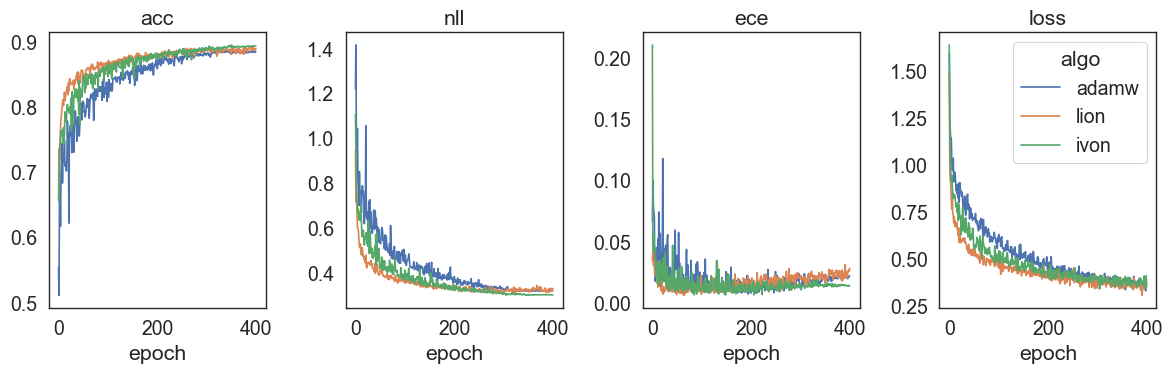

In [188]:
fig, axes = plt.subplots(1, 4, figsize=(12, 4))

for i, name in enumerate(['acc', 'nll', 'ece', 'loss']):
    for j, algo in enumerate(["adamw", "lion", "ivon"]):
        axes[i].plot(results[j][name], label=algo)

    axes[i].set_title(name)
    axes[i].set_xlabel('epoch')

plt.legend(title='algo')
fig.tight_layout()

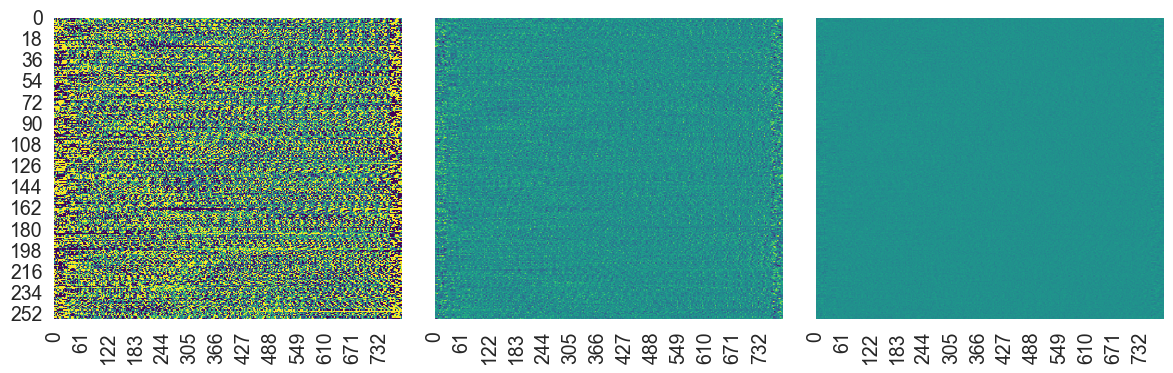

In [190]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharex='col', sharey=True)

for j in range(3):
    for l in [mus[j].linear_embed]:
        if isinstance(l, eqx.nn.Linear):
            sns.heatmap( l.weight, ax = axes[j], cmap='viridis', cbar=False, vmax=1.0, vmin=-1.0)

fig.tight_layout()

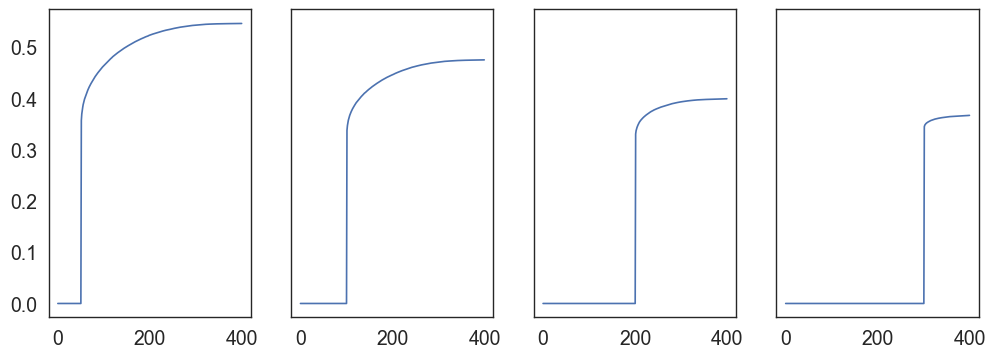

In [196]:
batch_size = 512
num_epochs = 400
mus_prune = []
sigmas_prune = []
results_prune = []

fig, axes = plt.subplots(1, 4, figsize=(12, 4), sharex=True, sharey=True)
for n, start_pruning in enumerate([50, 100, 200, 300]):
    for optim in [optimizer3]:
        rng_key, key = jr.split(rng_key)
        trained_smlp, final_opt_state, metrics = run_training(
            key,
            smlp, 
            optim, 
            train_ds, 
            test_ds, 
            num_epochs=num_epochs, 
            batch_size=batch_size,
            start_pruning=start_pruning
        )

        state = final_opt_state[0]
        params = eqx.filter(trained_smlp, eqx.is_array)
            
        mus_prune.append(params)
        results_prune.append(metrics)

    for i, l in enumerate([results_prune[n]["pf"].linear_embed]):
        axes[n].plot(l.weight, label=i)

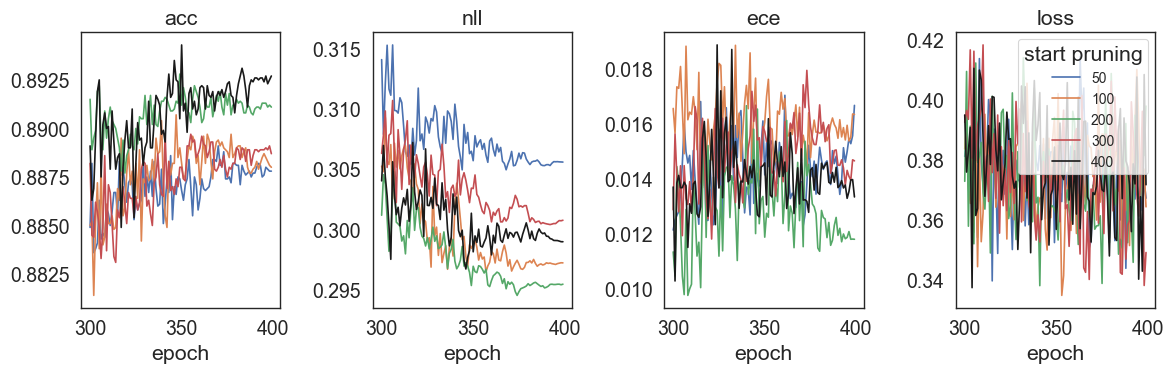

In [198]:
fig, axes = plt.subplots(1, 4, figsize=(12, 4))

for i, name in enumerate(['acc', 'nll', 'ece', 'loss']):
    for j, sp in enumerate([50, 100, 200, 300]):
        axes[i].plot(list(range(300, 400)), results_prune[j][name][-100:], label=sp)
    
    axes[i].plot(list(range(300, 400)), results[-1][name][-100:], 'k', label=400)
    axes[i].set_title(name)
    axes[i].set_xlabel('epoch')

plt.legend(title='start pruning', fontsize=10)
fig.tight_layout()

## Bottleneck MLP

In [217]:
batch_size = 512
num_epochs = 400
num_iters = num_epochs * len(train_ds['image']) // batch_size

augment = augmax.Chain(
  augmax.RandomSizedCrop(28, 28),
  augmax.HorizontalFlip()
)

lr_schd = optax.schedules.warmup_cosine_decay_schedule(
    1e-3 / 10,
    1e-3,
    num_iters // 10,
    num_iters,
    1e-5
)

optimizer1 = optax.adamw(lr_schd)

lr_schd = optax.schedules.warmup_cosine_decay_schedule(
    1e-4 / 10,
    1e-4,
    num_iters // 10,
    num_iters,
    1e-6
)
optimizer2 = optax.lion(lr_schd, weight_decay=0.)

In [218]:
rng_key, key = jr.split(rng_key)
bmlp = DeepMlp(
        img_size=in_size[:-1],
        in_channels=in_size[-1],
        embed_dim=256,
        num_classes=10,
        num_blocks=6,
        activation=nn.gelu,
        augmentation=augment,
        type="bottleneck",
        inference=False,
        key=key
)

In [219]:
mus = []
results = []

for optim in [optimizer1, optimizer2]:
    rng_key, key = jr.split(rng_key)
    trained_bmlp, final_opt_state, metrics = run_training(
        key,
        bmlp, 
        optim, 
        train_ds, 
        test_ds, 
        num_epochs=num_epochs, 
        batch_size=batch_size,
    )

    state = final_opt_state[0]
    params = eqx.filter(trained_bmlp, eqx.is_array)
        
    mus.append(params)
    results.append(metrics)

In [220]:
num_iters = num_epochs * len(train_ds['image']) // batch_size

lr_schd = optax.schedules.warmup_cosine_decay_schedule(
    1e-2,
    1e-1,
    num_iters // 10,
    num_iters,
    1e-4
)

rng_key, key = jr.split(rng_key)
optimizer3 = ivon(
    key,
    lr_schd,
    s0=1.,
    h0=1.0,
    num_data=len(train_ds['image']),
)

for optim in [optimizer3]:
    rng_key, key = jr.split(rng_key)
    trained_bmlp, final_opt_state, metrics = run_training(
        key,
        bmlp, 
        optim, 
        train_ds, 
        test_ds, 
        num_epochs=num_epochs, 
        batch_size=batch_size,
        start_pruning=num_epochs,
    )

    state = final_opt_state[0]
    params = eqx.filter(trained_bmlp, eqx.is_array)
        
    mus.append(params)
    results.append(metrics)

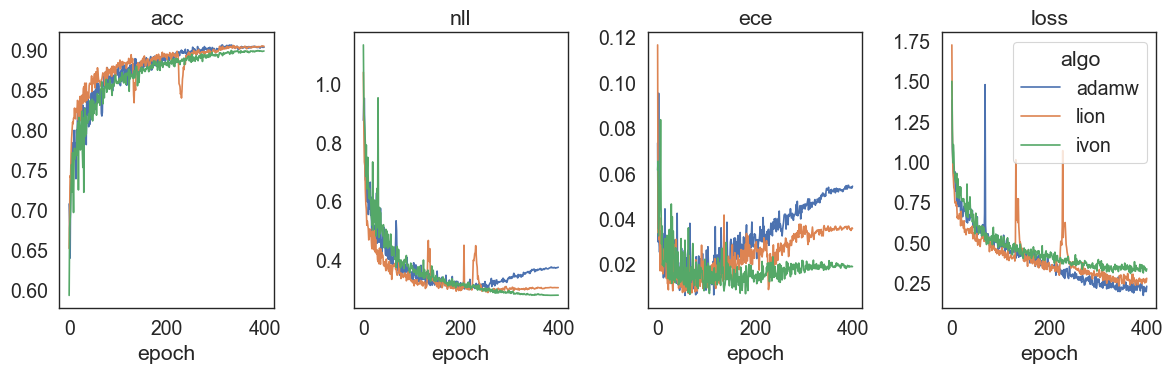

In [221]:
fig, axes = plt.subplots(1, 4, figsize=(12, 4))

for i, name in enumerate(['acc', 'nll', 'ece', 'loss']):
    for j, algo in enumerate(["adamw", "lion", "ivon"]):
        axes[i].plot(results[j][name], label=algo)

    axes[i].set_title(name)
    axes[i].set_xlabel('epoch')

plt.legend(title='algo')
fig.tight_layout()

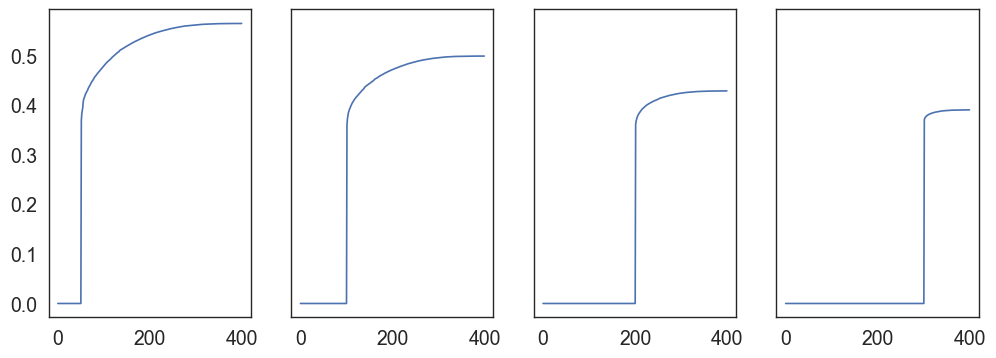

In [211]:
mus_prune = []
sigmas_prune = []
results_prune = []

fig, axes = plt.subplots(1, 4, figsize=(12, 4), sharex=True, sharey=True)
for n, start_pruning in enumerate([50, 100, 200, 300]):
    for optim in [optimizer3]:
        rng_key, key = jr.split(rng_key)
        trained_bmlp, final_opt_state, metrics = run_training(
            key,
            bmlp, 
            optim, 
            train_ds, 
            test_ds, 
            num_epochs=num_epochs, 
            batch_size=batch_size,
            start_pruning=start_pruning
        )

        state = final_opt_state[0]
        params = eqx.filter(trained_bmlp, eqx.is_array)
            
        mus_prune.append(params)
        results_prune.append(metrics)

    for i, l in enumerate([results_prune[n]["pf"].linear_embed]):
        axes[n].plot(l.weight, label=i)

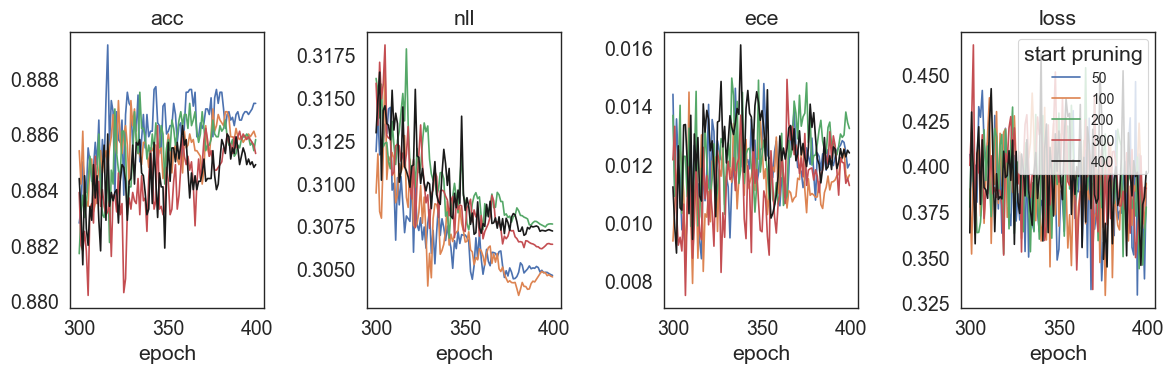

In [212]:
fig, axes = plt.subplots(1, 4, figsize=(12, 4))

for i, name in enumerate(['acc', 'nll', 'ece', 'loss']):
    for j, sp in enumerate([50, 100, 200, 300]):
        axes[i].plot(list(range(300, 400)), results_prune[j][name][-100:], label=sp)
    
    axes[i].plot(list(range(300, 400)), results[-1][name][-100:], 'k', label=400)
    axes[i].set_title(name)
    axes[i].set_xlabel('epoch')

plt.legend(title='start pruning', fontsize=10)
fig.tight_layout()

# CIFAR10

(36, 36, 3) 10


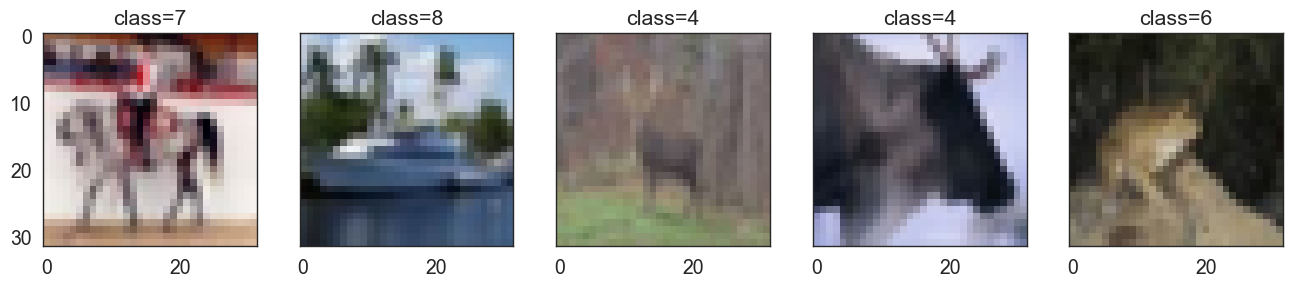

In [7]:
# load data
cif10_train_ds, cif10_test_ds = load_data('cifar10', platform='gpu', id=0)

fig, axes = plt.subplots(1, 5, figsize=(16, 3), sharex=True, sharey=True)
for n in range(5):
    axes[n].imshow(cif10_train_ds['image'][n]/255)
    axes[n].set_title('class={}'.format(cif10_train_ds['label'][n]))

cif10_train_ds['image'], cif10_test_ds['image'] = standardize(cif10_train_ds['image'], cif10_test_ds['image'], num_channels=3)

cif10_train_ds['image'] = jnp.pad(cif10_train_ds['image'], [(0, 0), (2, 2), (2, 2), (0, 0 )])
cif10_test_ds['image'] = jnp.pad(cif10_test_ds['image'], [(0, 0), (2, 2), (2, 2), (0, 0 )])

in_size_cif10 = cif10_train_ds['image'].shape[-3:]
out_size_cif10 = len(jnp.unique(cif10_train_ds['label']))

print(in_size_cif10, out_size_cif10)

augment = augmax.Chain(
  augmax.RandomSizedCrop(in_size_cif10[0], in_size_cif10[1]),
  augmax.HorizontalFlip()
)

rng_key, key = jr.split(rng_key)
mixer = MlpMixer(
    img_size=in_size_cif10[0],
    in_channels=in_size_cif10[-1], 
    patch_size=4,
    embed_dim=128,
    tokens_hidden_dim=64,
    hidden_dim_ratio=8,
    num_blocks=8,
    num_classes=out_size_cif10,
    activation=nn.gelu,
    patch_embed=PatchConvEmbed,
    key=key,
    augmentation=augment
)

lr_schd = optax.schedules.warmup_cosine_decay_schedule(
    1e-1 / 25,
    1e-1,
    40000 // 4,
    40000,
    1e-5
)

optimizer1 = optax.adamw(lr_schd)
optimizer2 = optax.adabelief(lr_schd)
rng_key, key = jr.split(rng_key)
optimizer3 = ivon(
    key,
    lr_schd,
    s0=1e2,
    h0=5e-1,
    num_data=len(cif10_train_ds['image']),
)

In [17]:
batch_size = 512
num_epochs = 200
num_iters = num_epochs * len(cif10_train_ds['image']) // batch_size

results_cif10 = []

lr_schd = optax.schedules.warmup_cosine_decay_schedule(
    1e-3 / 10,
    1e-3,
    num_iters // 10,
    num_iters,
    1e-5
)

optimizer1 = optax.adamw(lr_schd)

lr_schd = optax.schedules.warmup_cosine_decay_schedule(
    1e-4 / 10,
    1e-4,
    num_iters // 10,
    num_iters,
    1e-6
)
optimizer2 = optax.lion(lr_schd, weight_decay=0.)

for optim in [optimizer1, optimizer2]:
    rng_key, key = jr.split(rng_key)
    _, final_opt_state, metrics = run_training(
        key,
        mixer, 
        optim, 
        cif10_train_ds, 
        cif10_test_ds, 
        num_epochs=num_epochs,
        batch_size=batch_size
    )

    results_cif10.append(metrics)

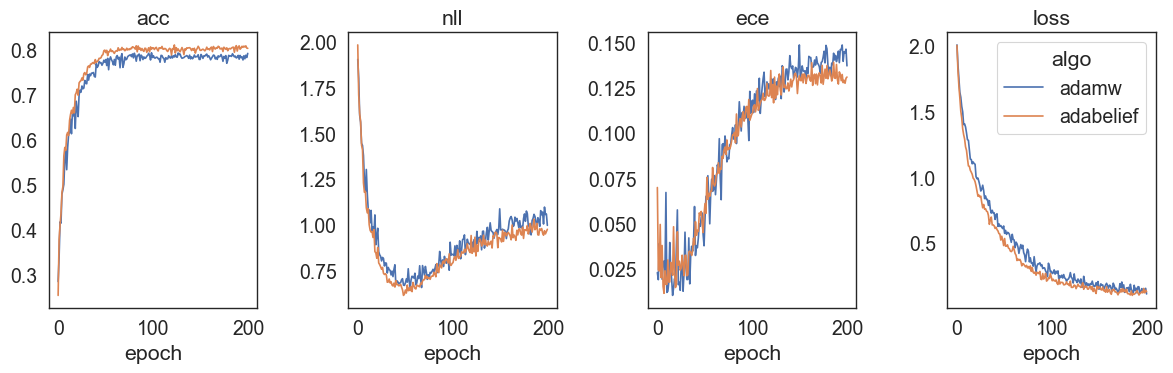

In [13]:
fig, axes = plt.subplots(1, 4, figsize=(12, 4))

for i, name in enumerate(['acc', 'nll', 'ece', 'loss']):
    for j, algo in enumerate(["adamw", "adabelief"]):
        axes[i].plot(results_cif10[j][name], label=algo)

    axes[i].set_title(name)
    axes[i].set_xlabel('epoch')

plt.legend(title='algo')
fig.tight_layout()

In [23]:
datasize = len(cif10_train_ds['image'])
num_iters = num_epochs * datasize // batch_size

lr_schd = optax.schedules.warmup_cosine_decay_schedule(
    1e-2,
    1e-1,
    num_iters // 5,
    num_iters,
    1e-4
)

rng_key, key = jr.split(rng_key)
optimizer3 = ivon(
    key,
    lr_schd,
    s0=1.,
    h0=1.0,
    num_data=datasize,
)

for optim in [optimizer3]:
    rng_key, key = jr.split(rng_key)
    _, _, metrics = run_training(
        key,
        mixer, 
        optim, 
        cif10_train_ds, 
        cif10_test_ds, 
        num_epochs=num_epochs, 
        batch_size=batch_size,
        start_pruning=num_epochs
    )
    
    # results_cif10.append(metrics)
    results_cif10[-1] = metrics

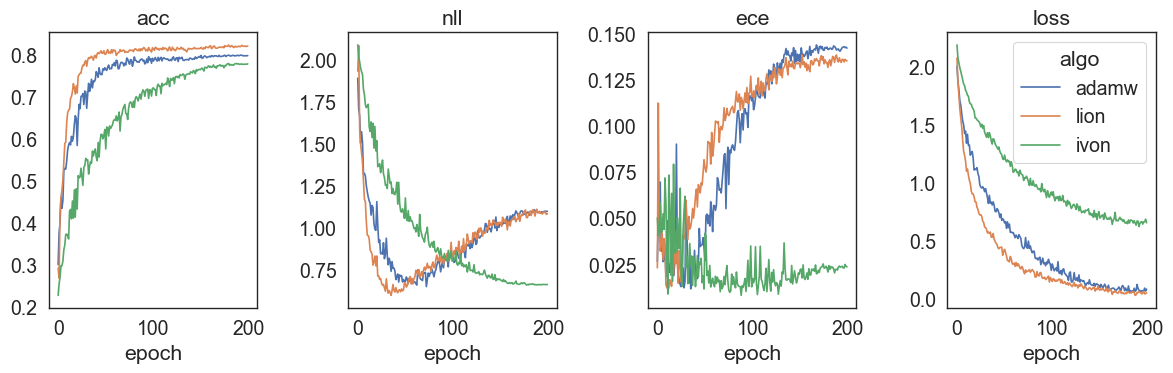

In [24]:
fig, axes = plt.subplots(1, 4, figsize=(12, 4))

for i, name in enumerate(['acc', 'nll', 'ece', 'loss']):
    for j, algo in enumerate(["adamw", "lion", "ivon"]):
        axes[i].plot(results_cif10[j][name], label=algo)

    axes[i].set_title(name)
    axes[i].set_xlabel('epoch')

plt.legend(title='algo')
fig.tight_layout()

In [25]:
datasize = len(cif10_train_ds['image'])
num_iters = num_epochs * datasize // batch_size

lr_schd = optax.schedules.warmup_cosine_decay_schedule(
    1e-2,
    1e-1,
    num_iters // 5,
    num_iters,
    1e-4
)

rng_key, key = jr.split(rng_key)
optimizer3 = ivon(
    key,
    lr_schd,
    s0=1.,
    h0=.5,
    num_data=datasize,
)

for optim in [optimizer3]:
    rng_key, key = jr.split(rng_key)
    _, _, metrics = run_training(
        key,
        mixer, 
        optim, 
        cif10_train_ds, 
        cif10_test_ds, 
        num_epochs=num_epochs, 
        batch_size=batch_size,
        start_pruning=num_epochs
    )
    
    # results_cif10.append(metrics)
    results_cif10[-1] = metrics

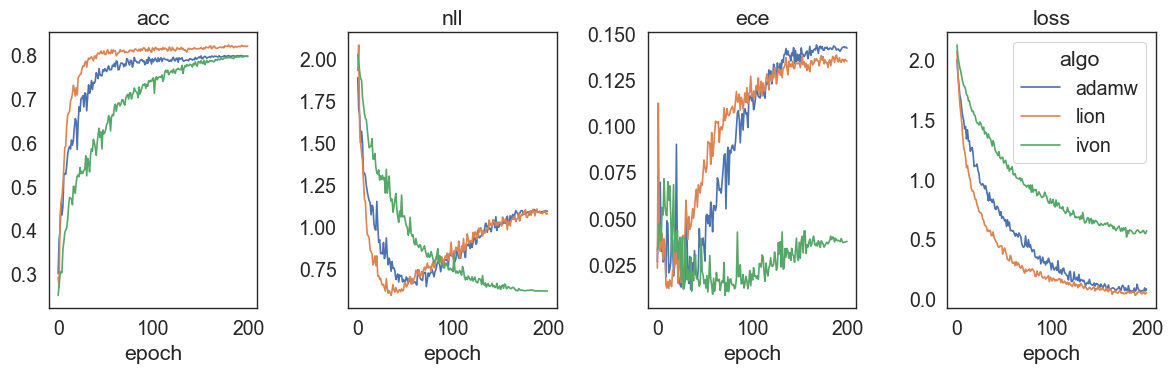

In [26]:
fig, axes = plt.subplots(1, 4, figsize=(12, 4))

for i, name in enumerate(['acc', 'nll', 'ece', 'loss']):
    for j, algo in enumerate(["adamw", "lion", "ivon"]):
        axes[i].plot(results_cif10[j][name], label=algo)

    axes[i].set_title(name)
    axes[i].set_xlabel('epoch')

plt.legend(title='algo')
fig.tight_layout()

In [ ]:
batch_size = 128
num_epochs = 100
mus_prune_cif10 = []
results_prune_cif10 = []

for n, start_pruning in enumerate([1, 20, 40, 60, 80]):
    for optim in [optimizer3]:
        rng_key, key = jr.split(rng_key)
        trained_mixer, _, metrics = run_training(
            key,
            mixer, 
            optim, 
            cif10_train_ds, 
            cif10_test_ds, 
            num_epochs=num_epochs, 
            batch_size=batch_size,
            start_pruning=start_pruning
        )

        state = final_opt_state[0]
        params = eqx.filter(trained_mixer, eqx.is_array)
            
        mus_prune_cif10.append(params)
        results_prune_cif10.append(metrics)

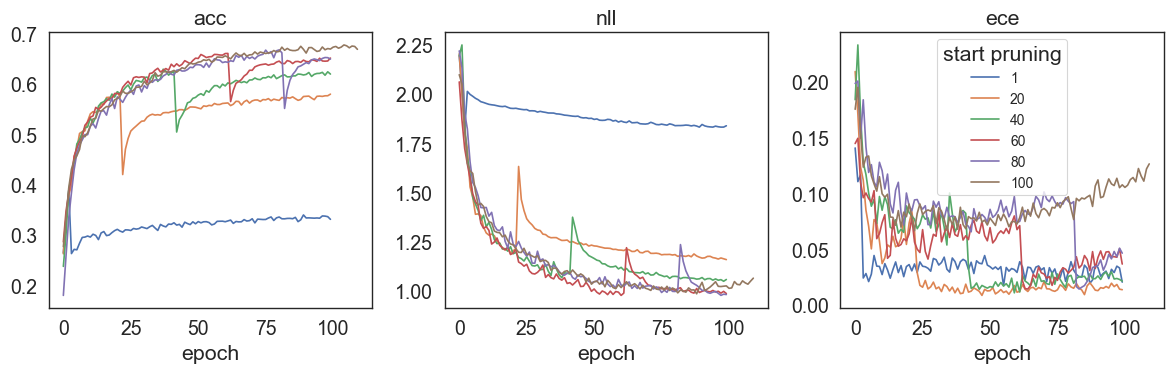

In [31]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for i, name in enumerate(['acc', 'nll', 'ece']):
    for j, sp in enumerate([1, 20, 40, 60, 80]):
        axes[i].plot(results_prune_cif10[j][name], label=sp)

    axes[i].plot(results_cif10[-1][name][:110], label=100)
    axes[i].set_title(name)
    axes[i].set_xlabel('epoch')

plt.legend(title='start pruning', fontsize=10)
fig.tight_layout()

# CIFAR100

(3, 36, 36) 100


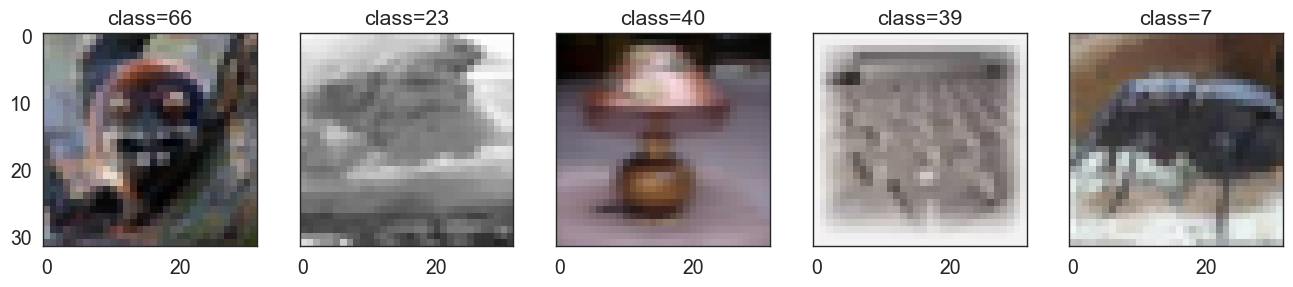

In [12]:
# load data
cif100_train_ds, cif100_test_ds = load_data('cifar100', platform='gpu', id=0)

in_size_cif100 = cif100_train_ds['image'].shape[-3:]
out_size_cif100 = len(jnp.unique(cif100_train_ds['label']))

fig, axes = plt.subplots(1, 5, figsize=(16, 3), sharex=True, sharey=True)
for n in range(5):
    axes[n].imshow(cif100_train_ds['image'][n]/255)
    axes[n].set_title('class={}'.format(cif100_train_ds['label'][n]))

cif100_train_ds['image'], cif100_test_ds['image'] = standardize(cif100_train_ds['image'], cif100_test_ds['image'], num_channels=3)

cif100_train_ds['image'] = jnp.pad(cif100_train_ds['image'].transpose(0, 3, 1, 2), ((0, 0), (0, 0), (2, 2), (2, 2)))
cif100_test_ds['image'] = jnp.pad(cif100_test_ds['image'].transpose(0, 3, 1, 2), ((0, 0), (0, 0), (2, 2), (2, 2)))

in_size_cif100 = cif100_train_ds['image'].shape[-3:]
out_size_cif100 = len(jnp.unique(cif100_train_ds['label']))

print(in_size_cif100, out_size_cif100)

rng_key, key = jr.split(rng_key)
mixer = MlpMixer(
    img_size=in_size_cif100[1],
    in_channels=in_size_cif100[0], 
    patch_size=4,
    embed_dim=128,
    tokens_hidden_dim=64,
    hidden_dim_ratio=8,
    num_blocks=8,
    num_classes=out_size_cif100,
    activation=nn.gelu,
    patch_embed=PatchConvEmbed,
    key=key
)

lr_schd = optax.schedules.warmup_cosine_decay_schedule(
    1e-1 / 25,
    1e-1,
    40000 // 4,
    40000,
    1e-5
)

optimizer1 = optax.adamw(lr_schd)
optimizer2 = optax.adabelief(lr_schd)
rng_key, key = jr.split(rng_key)
optimizer3 = ivon(
    key,
    lr_schd,
    s0=1e2,
    h0=5e-1,
    num_data=len(cif100_train_ds['image']),
)

batch_size = 128
num_epochs = 100

In [13]:
results_cif100 = []

for optim in [optimizer1, optimizer2]:
    rng_key, key = jr.split(rng_key)
    _, _, metrics = run_training(
        key,
        mixer, 
        optim, 
        cif100_train_ds, 
        cif100_test_ds, 
        num_epochs=num_epochs, 
        batch_size=batch_size
    )

    results_cif100.append(metrics)

In [14]:
for optim in [optimizer3]:
    rng_key, key = jr.split(rng_key)
    _, _, metrics = run_training(
        key,
        mixer, 
        optim, 
        cif100_train_ds, 
        cif100_test_ds, 
        num_epochs=num_epochs, 
        batch_size=batch_size,
        start_pruning=num_epochs
    )
    
    results_cif100.append(metrics)

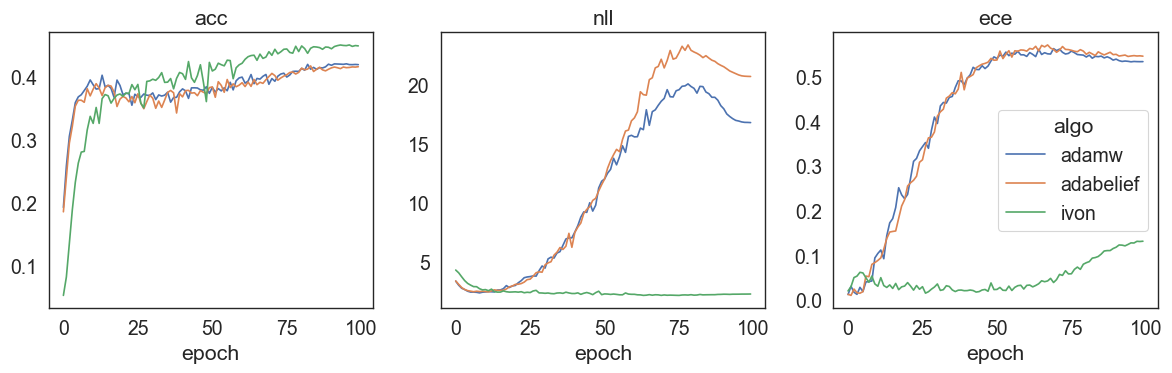

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for i, name in enumerate(['acc', 'nll', 'ece']):
    for j, algo in enumerate(["adamw", "adabelief", "ivon"]):
        axes[i].plot(results_cif100[j][name], label=algo)

    axes[i].set_title(name)
    axes[i].set_xlabel('epoch')

plt.legend(title='algo')
fig.tight_layout()

In [16]:
batch_size = 128
num_epochs = 120
mus_prune_cif100 = []
results_prune_cif100 = []

for n, start_pruning in enumerate([1, 20, 40, 60, 80]):
    for optim in [optimizer3]:
        rng_key, key = jr.split(rng_key)
        trained_mixer, _, metrics = run_training(
            key,
            mixer, 
            optim, 
            cif100_train_ds, 
            cif100_test_ds, 
            num_epochs=num_epochs, 
            batch_size=batch_size,
            start_pruning=start_pruning
        )

        params = eqx.filter(trained_mixer, eqx.is_array)
            
        mus_prune_cif100.append(params)
        results_prune_cif100.append(metrics)

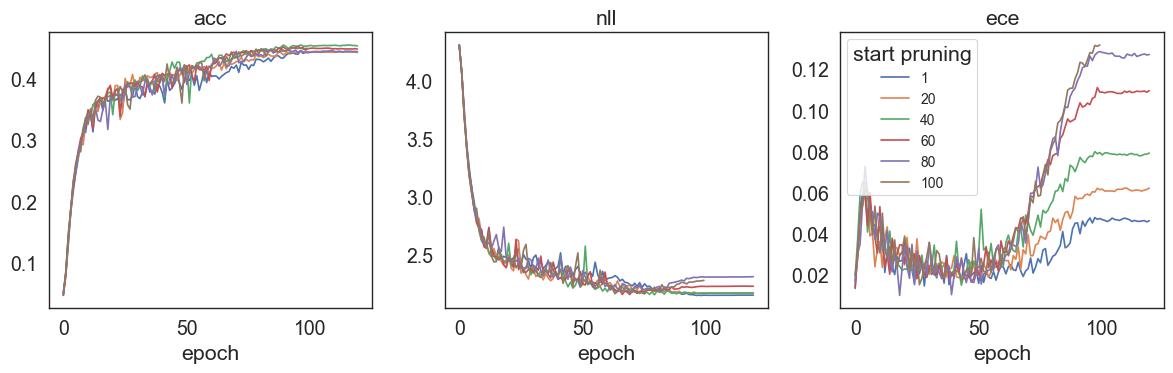

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for i, name in enumerate(['acc', 'nll', 'ece']):
    for j, sp in enumerate([1, 20, 40, 60, 80]):
        axes[i].plot(results_prune_cif100[j][name], label=sp)

    axes[i].plot(results_cif100[-1][name][:110], label=100)
    axes[i].set_title(name)
    axes[i].set_xlabel('epoch')

plt.legend(title='start pruning', fontsize=10)
fig.tight_layout()